In [30]:
cd ..

/home/m13uz/groningen


In [88]:
import tensorflow as tf
import matplotlib
import numpy as np
import pandas as pd
import json
import os
import itertools
import functools
import data.helpers as helpers
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
def plot_slice(tslice):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.heatmap(tslice, ax=ax)
    #ax.set_aspect('equal')
    #ax.scatter(quake_x,quake_y, marker='o', color = 'r', s=50)
    sns.despine()
    fig.tight_layout()
    #fig.savefig('inspecttile', dpi=600)

In [4]:
def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])
def fizz_buzz_encode(i):
    if   i % 15 == 0: return 0#np.array([0, 0, 0, 1])
    elif i % 5  == 0: return 1 #np.array([0, 0, 1, 0])
    elif i % 3  == 0: return 2#np.array([0, 1, 0, 0])
    else:             return 3#np.array([1, 0, 0, 0])

def invert(label, sample):
    if label == 3:
        return sample
    else:
        return {0:'fizzbuzz', 1:'fizz',2:'buzz'}[label]
def generate_training(num_digits, therange):
    for i in range(*therange):
        yield binary_encode(i, num_digits)
names=[str(i) for i in range(12)]
train_x = pd.DataFrame((i for i in generate_training(12,(101,1024))), columns=names)
test_range = (0,100)
train_range = (101,1024)
train_y = np.asarray([fizz_buzz_encode(i) for i in range(*train_range)])
test_x = pd.DataFrame((i for i in generate_training(12,test_range)),columns=names)
test_y = np.asarray([fizz_buzz_encode(i) for i in range(*test_range)])

In [83]:
def get_fnames():
    prefix = 'data/tiles/'
    fnames = [prefix+i for i in os.listdir(prefix)
             if i.split('.')[-1] == 'txt']
    return fnames
def parse_filename(fname):
    no_prefix = fname.strip('data/tiles')
    eventid, seq_id = no_prefix.split('_')
    return eventid, int(seq_id.strip('.txt'))
def get_label(metadata, filename):
    eventid, seqid = parse_filename(filename)
    label = metadata[eventid]
    return label

def format_frames(metadata,frames):
    """frames is a sequence of (eventid,seqnum,array)"""
    frame_group = list(frames)
    label = metadata[frames[0][0]]
    return np.dstack([np.loadtxt(frame[2]) for frame in frame_group]), label
def gen(metadatafile,frames_per_eg, datafilenames):
    with open(metadatafile) as f:
        metadata = json.load(f)
    loaded_files = ((*parse_filename(fname),fname)
                    for fname in datafilenames) #np.loadtxt here in real execution
    sorted_by_event = sorted(loaded_files, key=lambda x:x[0])
    grouped_by_event = itertools.groupby(sorted_by_event, key = lambda x:x[0])
    inorder_by_event = (sorted(g, key = lambda x:x[1]) for k,g in grouped_by_event)
    window_groups_by_event = (helpers.grouper(frames_per_eg, group)
                              for group in inorder_by_event)
    formatted = (format_frames(metadata,framegroup) for framegroup
                 in itertools.chain(*window_groups_by_event))
    return formatted
    #for idx, row in x.iterrows():
    #    data = np.asarray([row,
    #                       row])
    #    data = np.dstack((data,data, data))
    #    label = y[idx]
    #    yield data, label
def train_input_fn(features, labels, batch_size=20, repeat=100):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.map(namer)
    dataset = tf.data.Dataset.from_generator(lambda: gen(features, labels)
                                             ,output_types=(tf.int64, tf.int64)
                                             ,output_shapes = (tf.TensorShape([2,12,3]),
                                                               tf.TensorShape([]))
                                            )
    # Shuffle, repeat, and batch the examples.
    #dataset = dataset.shuffle(1000).repeat(repeat).batch(batch_size)
    # Return the dataset.
    iterator = dataset.make_one_shot_iterator()
    d,l = iterator.get_next()
    return {'image':d}, l

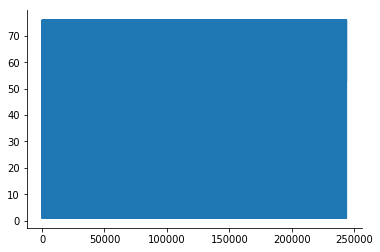

In [98]:
def num_nonzeros(fname):
    return len(nonzeroidxs(np.loadtxt(fname)))
def nonzeroidxs(arr):
    return list(zip(*np.nonzero(arr)))
nonzerocounts = [num_nonzeros(f) for f in get_fnames()]
fig,ax =plt.subplots(1)
ax.plot(nonzerocounts)
sns.despine()

In [92]:
vid = next(gen('data/tiles/metadata.json',10, get_fnames()))
np.shape(vid[0])

(90, 180, 10)

(array([73]), array([63]))

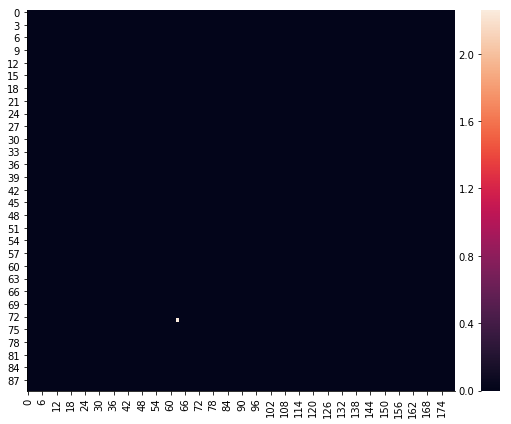

In [97]:
plot_slice(vid[0][:,:,8])
np.nonzero(vid[0][:,:,8])

In [86]:
with tf.Session() as sess:
    n = train_input_fn(train_x, train_y)
    print(sess.run(n))

InvalidArgumentError: TypeError: gen() missing 1 required positional argument: 'datafilenames'
	 [[Node: PyFunc = PyFunc[Tin=[DT_INT64], Tout=[DT_INT64, DT_INT64], token="pyfunc_15"](arg0)]]
	 [[Node: IteratorGetNext_7 = IteratorGetNext[output_shapes=[[2,12,3], []], output_types=[DT_INT64, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_7)]]

In [76]:
np.dstack([1,1,1])

array([[[1, 1, 1]]])